## Nomalizing images to greyscale (0-255) and get points with the mouse

In [1]:
def on_left_button(event, x, y, flags, params):    
    """ Mouse callback
    params = user data"""
    if event == cv2.EVENT_LBUTTONDOWN:
        img, name = params[0], params[1]
        height, width = img.shape[:2]
        if x > (width/2):
            xy = "%d,%d" % (x - (width/2), y)
        else:
            xy = "%d,%d" % (x, y)
        cv2.circle(img, (x, y), 1, (255, 255, 255), thickness=-1)
        cv2.putText(img, xy, (x, y), cv2.FONT_HERSHEY_PLAIN,
                    1.0, (255, 255, 255), thickness=1)
        cv2.imshow(name, img)
        print(xy)

def normilize(img, coefficient):
    """ 
    normilize brightness to (0 - coefficient) grey value 
    """
    
    max_val = np.amax(img)
    min_val = np.amin(img)
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if np.isnan(img[i][j]):
                img[i][j] = 0
            img[i][j] = (img[i][j] - min_val)/(max_val - min_val) * coefficient
    return img

def gamma_correction(img, gamma):
    look_up_table = np.empty((1,256), np.uint8)
    for i in range(256):
        look_up_table[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    img = cv2.LUT(img, look_up_table)
    
import numpy as np
import cv2
left = cv2.imread("./ConstructionSite-left/image0110_c0.pgm", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("./ConstructionSite-right/image0110_c1.pgm", cv2.IMREAD_GRAYSCALE)

stereo_pair = [left, right]

# apply all processing to each image in stereo_pair
for img in stereo_pair:
    img = normilize(img, 255);
    img = gamma_correction(img, 0.4);
    

In [ ]:
cv2.namedWindow("Stereo pair")
image_concatenated = cv2.hconcat(stereo_pair)
cv2.setMouseCallback("Stereo pair", on_left_button, [image_concatenated, "Stereo pair"])
cv2.imshow("Stereo pair", image_concatenated)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Calculating 3D points

In [2]:
from math import cos, sin

def euler_rot_mat(x, y, z):
    R_x = np.asarray([[1, 0, 0], [0, cos(x), sin(x)], [0, -sin(x), cos(x)]], dtype = np.float64)
    R_y = np.asarray([[cos(y), 0, -sin(y)], [0, 1, 0], [sin(y), 0, cos(y)]], dtype = np.float64)
    R_z = np.asarray([[cos(z), sin(z), 0], [-sin(z), cos(z), 0], [0, 0, 1]], dtype = np.float64)
    R_zyx = R_x @ R_y @ R_z
    return R_zyx
        
def calculate_3d_points(image_coordinates, disparities): 
    """
    calculation points in world coordinate system according to intrinsic and extrinsic parameters.
    image_coordinates = [[u0, v0], 
                         [u1, v1], 
                            ...  ,
                         [un,vn]]
    disparities = [d0, d1, ..., dn]
    """
    points = []
    # intrinsic parameters
    f = 820.428 # pixels
    s = 1.0003 # pixels
    u0 = 305.2 # pixels
    v0 = 239.826 # pixels
    pixel_size = 0.000008 # m
    
    # extrimsic parameters
    tilt = 0.06 # rad
    roll = 0;   # rad
    yaw = 0.01  # rad
    latpos = -0.07/pixel_size
    height = 1.26/pixel_size
    distance = 2.0/pixel_size
    B = 0.308084/pixel_size

    for [u, v], disparity in zip(image_coordinates, disparities):     
        
        #distance to point orthogonal to image plane
        z = f * (B / disparity)
        
        p_im = np.asarray([[z*u, z*v, z, 1]], dtype = np.float64);
        p_im = p_im.transpose()
        
        # projection matrix
        K = np.asarray([[f, 0, u0, 0], [0, s*f, v0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], \
                       dtype=np.float64);

        # Translation matrix cam -> image
        R_cam_to_im = euler_rot_mat(-np.pi/2, 0, -np.pi/2);
        
        # append zeros as addintional column
        T_cam_to_im = np.c_[R_cam_to_im, np.transpose([[0,0,0]])];
        
        # append as addintional row
        T_cam_to_im = np.r_[T_cam_to_im, [[0,0,0,1]]]

        # Translation matrix world -> cam
        R_world_to_cam = euler_rot_mat(roll, tilt, yaw);
        
        # append zeros as addintional column
        T_world_to_cam = np.c_[R_world_to_cam, np.transpose([[distance, -latpos, -height]])];
        
        # append as addintional row
        T_world_to_cam = np.r_[T_world_to_cam, [[0,0,0,1]]]
        
        pt_world = np.linalg.inv(K @ T_cam_to_im @ T_world_to_cam) @ p_im # pixels
        pt_world_meters = pt_world[:3,0] * pixel_size;
    
        points.append(pt_world_meters.tolist())
    
    return points

### Calculating 3D point of given point

In [3]:
given_point = [[249,234]]
d = [10]
points = calculate_3d_points(given_point, d)
print(points)

[[23.30272391429426, 1.8945501620937555, 0.04111904833189863]]


## Disparity map using Normalized Cross-Correlation 
(Reference used: : https://www.programmersought.com/article/50045374193/)

In [4]:
def disparity_map(stereo_pair, kern_width, max_disparity):
    """ 
    Use normalized cross-correlation to calculate disparity image 
    """
    if kern_width % 2 == 0:
        kern_width += 1
    kern_size = (kern_width, kern_width)
    
    left, right = stereo_pair[0].astype(np.float64), stereo_pair[1].astype(np.float64)
    m,n = left.shape[:2]
    
    mean_left = mean_right = s = s_left = s_right = np.zeros((m,n))
    
    mean_left = cv2.GaussianBlur(left, kern_size, 0)
    mean_right = cv2.GaussianBlur(right, kern_size, 0)
    
    disp_maps = np.zeros((m,n,max_disparity))
    
    norm_left = left - mean_left
    norm_right = right - mean_right

    
    for step in range(max_disparity):            
        s = cv2.GaussianBlur(np.roll(norm_left, -step) * norm_right, kern_size, 0) 
        s_left = cv2.GaussianBlur(np.roll(norm_left, -step) * np.roll(norm_left, -step), kern_size, 0)
        s_right = cv2.GaussianBlur(norm_right * norm_right, kern_size, 0)
        
        # Save ncc score
        disp_maps[:,:, step] = s / (np.sqrt(s_left * s_right))
        
    disparity_map = np.argmax(disp_maps, axis=2)
    disparity_map = disparity_map.astype(np.uint8)
    

    return disparity_map

In [5]:
import numpy as np
import cv2
left = cv2.imread("./ConstructionSite-left/image0110_c0.pgm", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("./ConstructionSite-right/image0110_c1.pgm", cv2.IMREAD_GRAYSCALE)

stereo_pair = [left, right]

dmap = disparity_map(stereo_pair, 51, stereo_pair[0].shape[1])

In [ ]:
name = "Disparity map"
disp_colormap = cv2.applyColorMap(dmap, cv2.COLORMAP_JET)
cv2.namedWindow(name)
cv2.imshow(name, disp_colormap)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Feature matching and ICP

### Functions

In [6]:
def get_keypoints(img):
    orb = cv2.ORB_create(200)
    kps = orb.detect(stereo_pair[0], None)
    kps, des = orb.compute(stereo_pair[0], kps)
    new_img = cv2.drawKeypoints(stereo_pair[0], kps, None, color=(0,0,255), flags=0)
    
    return new_img, kps, des

# convert keypoints to world coordinate system
def get_world_points(kps, dmap):
    kps_coordinates = [kp.pt for kp in kps]
    kps_coordinates = np.asarray(kps_coordinates, dtype=np.uint32)
    disps = [dmap[x,y] for y,x in kps_coordinates]
    pts_world = calculate_3d_points(kps_coordinates, disps)
    pts_world = np.asarray(pts_world, dtype = np.float64)
    return pts_world

### Calculating points for image0110_c0.pgm

Text(0.5, 0, 'Z Label')

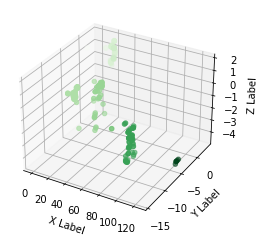

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
left = cv2.imread("./ConstructionSite-left/image0110_c0.pgm", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("./ConstructionSite-right/image0110_c1.pgm", cv2.IMREAD_GRAYSCALE)

stereo_pair = [left, right]
# apply all processing to each image in stereo_pair
for img in stereo_pair:
    img = normilize(img, 255);

dmap = disparity_map(stereo_pair, 51, stereo_pair[0].shape[1])

left_with_kp, kps, des = get_keypoints(stereo_pair[0])

# cv2.namedWindow("Corner-like features")
# cv2.imshow("Corner-like features", left_with_kp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

pts_world = get_world_points(kps, dmap)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pts_world[:,0], pts_world[:,1], pts_world[:,2], c=pts_world[:,0], cmap='Greens');
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

### Calculating points for image0112_c0.pgm 

<ipython-input-2-560deba641e4>:39: RuntimeWarning: divide by zero encountered in true_divide
  z = f * (B / disparity)
<ipython-input-2-560deba641e4>:66: RuntimeWarning: invalid value encountered in matmul
  pt_world = np.linalg.inv(K @ T_cam_to_im @ T_world_to_cam) @ p_im # pixels


Text(0.5, 0, 'Z Label')

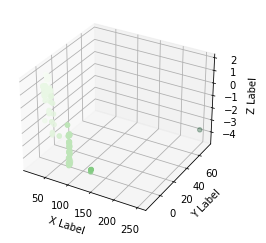

In [8]:
left_2 = cv2.imread("./ConstructionSite-left/image0112_c0.pgm", cv2.IMREAD_GRAYSCALE)
right_2 = cv2.imread("./ConstructionSite-right/image0112_c1.pgm", cv2.IMREAD_GRAYSCALE)

stereo_pair_2 = [left_2, right_2]
# apply all processing to each image in stereo_pair
for img in stereo_pair_2:
    img = normilize(img, 255);

dmap_2 = disparity_map(stereo_pair_2, 51, stereo_pair_2[0].shape[1])

left_with_kp_2, kps_2, des_2 = get_keypoints(stereo_pair_2[0])
pts_world_2 = get_world_points(kps_2, dmap_2)

fig_2 = plt.figure()
ax_2 = plt.axes(projection='3d')
ax_2.scatter3D(pts_world_2[:,0], pts_world_2[:,1], pts_world_2[:,2], c=pts_world_2[:,0], cmap='Greens');
ax_2.set_xlabel('X Label')
ax_2.set_ylabel('Y Label')
ax_2.set_zlabel('Z Label')

In [ ]:
cv2.namedWindow("Corner-like features")
cv2.imshow("Corner-like features", left_with_kp_2)
cv2.waitKey(0)
cv2.destroyAllWindows()

### ICP image0112 and image 0110

In [9]:
def center_of_gravity(points):
    m,n = points.shape
    N = len(points[1,:])
    cog = np.zeros([m,1], dtype = np.float64)
    for i in range(m):
        cog[i] = np.sum(points[i,:])/N
    return cog

In [10]:
# firstly filter inappropriate (singular) points (nan)
x_bool = ~np.isnan(pts_world)
p_bool = ~np.isnan(pts_world_2)
both_bool = np.logical_and(x_bool,p_bool)
x = pts_world[both_bool.any(axis=1)].transpose()
p = pts_world_2[both_bool.any(axis=1)].transpose()

# find centers of gravity of 2 point sets 
mu_x = center_of_gravity(x)
mu_p = center_of_gravity(p)

# Resulting point sets
x_res = x - mu_x
p_res = p - mu_p

### SVD 
(Source: https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.html , lecture notes)

In [11]:
W = x_res @ p_res.transpose()
eig_U, U = np.linalg.eig(W @ W.transpose())
eig_V, V = np.linalg.eig(W.transpose() @ W)

R = U @ V.transpose()
t = mu_x - R @ mu_p

x_matched = (R @ x) + t

Rotatiton matrix and translation vector

In [12]:
R, t

(array([[ 0.99932357, -0.03635034,  0.00557233],
        [ 0.03610292,  0.99856912,  0.03944979],
        [-0.00699837, -0.03922193,  0.99920602]]),
 array([[ 0.36055407],
        [-2.32615912],
        [ 0.18177338]]))

### Plotting matched points of image0110_c0.pgm & image0112_c0.pgm

3D plot

Text(0.5, 0, 'Z Label')

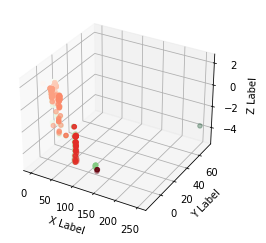

In [13]:
fig_res = plt.figure()
ax_res = plt.axes(projection='3d')
ax_res.scatter3D(p[0,:], p[1,:], p[2,:], c=p[0,:], cmap='Greens');
ax_res.scatter3D(x_matched[0,:], x_matched[1,:], x_matched[2,:], c=x_matched[0,:], cmap='Reds');
ax_res.set_xlabel('X Label')
ax_res.set_ylabel('Y Label')
ax_res.set_zlabel('Z Label')

2D plot of matching point sets

Text(0, 0.5, 'Y')

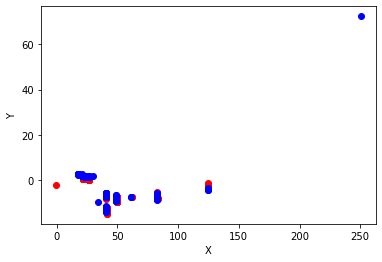

In [14]:
fig_2d = plt.figure()
plt.plot(x_matched[0,:], x_matched[1,:], 'o', color='red')
plt.plot(p[0,:], p[1,:], 'o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')

How much did car travel between image0110 and image0112

In [15]:
travel_distance = np.linalg.norm(t)
print(travel_distance, "meters")

2.360944101309952 meters


### Plotting matched points of image0113_c0.pgm & image0114_c0.pgm

In [16]:
im13_l = cv2.imread("./ConstructionSite-left/image0113_c0.pgm", cv2.IMREAD_GRAYSCALE)
im13_r = cv2.imread("./ConstructionSite-right/image0113_c1.pgm", cv2.IMREAD_GRAYSCALE)
im14_l = cv2.imread("./ConstructionSite-left/image0114_c0.pgm", cv2.IMREAD_GRAYSCALE)
im14_r = cv2.imread("./ConstructionSite-right/image0114_c1.pgm", cv2.IMREAD_GRAYSCALE)

stereo_pairs = [[im13_l, im13_r], [im14_l, im14_r]]
pts = []
# apply all processing to each image in stereo_pair
for stereo_pair in stereo_pairs:
    for img in stereo_pair:
        img = normilize(img, 255);
        
    dmap = disparity_map(stereo_pair, 51, stereo_pair[0].shape[1])
    
#     cv2.namedWindow("Debug")
#     cv2.imshow("Debug", dmap)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    left_with_kp, kps, des = get_keypoints(stereo_pair[0])
    pts_world = get_world_points(kps, dmap)
    pts.append(pts_world)
    

<ipython-input-2-560deba641e4>:39: RuntimeWarning: divide by zero encountered in true_divide
  z = f * (B / disparity)
<ipython-input-2-560deba641e4>:66: RuntimeWarning: invalid value encountered in matmul
  pt_world = np.linalg.inv(K @ T_cam_to_im @ T_world_to_cam) @ p_im # pixels


Text(0.5, 0, 'Z')

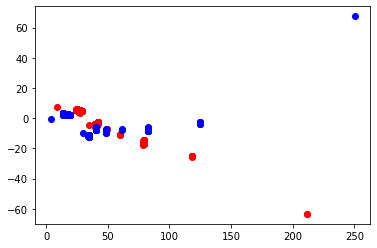

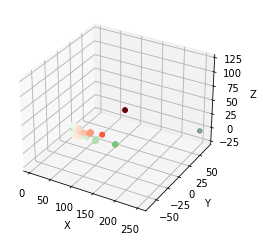

In [17]:
# firstly filter inappropriate (singular) points (nan)
x0 = pts[0]
p0 = pts[1]
x_bool = ~np.isnan(x0)
p_bool = ~np.isnan(p0)
both_bool = np.logical_and(x_bool,p_bool)
x = x0[both_bool.any(axis=1)].transpose()
p = p0[both_bool.any(axis=1)].transpose()

# find centers of gravity of 2 point sets 
mu_x = center_of_gravity(x)
mu_p = center_of_gravity(p)

# Resulting point sets
x_res = x - mu_x
p_res = p - mu_p

# SVD
W = x_res @ p_res.transpose()
eig_U, U = np.linalg.eig(W @ W.transpose())
eig_V, V = np.linalg.eig(W.transpose() @ W)

R = U @ V.transpose()
t = mu_x - R @ mu_p

x_matched = (R @ x) + t


# 2D plot of matching point 13 and 14 images
fig_2d = plt.figure()
plt.plot(x_matched[0,:], x_matched[1,:], 'o', color='red')
plt.plot(p[0,:], p[1,:], 'o', color='blue')

fig_res = plt.figure()
ax_res = plt.axes(projection='3d')
ax_res.scatter3D(p[0,:], p[1,:], p[2,:], c=p[0,:], cmap='Greens');
ax_res.scatter3D(x_matched[0,:], x_matched[1,:], x_matched[2,:], c=x_matched[0,:], cmap='Reds');
ax_res.set_xlabel('X')
ax_res.set_ylabel('Y')
ax_res.set_zlabel('Z')

#### Results: 2D and 3D plots look fine, but traveled distance seems to be wrong for 13th and 14th image.
#### The results for 10th and 12th image are quite decent

In [18]:
travel_distance = np.linalg.norm(t)
print(travel_distance, "meters")

24.328170733393826 meters
